In [1]:
# @title Dowloand the demo data
# Let's start with loading the image for segmentation

!wget https://polybox.ethz.ch/index.php/s/ddFUpadTSRgDycr/download -O image_examples.zip
!unzip image_examples.zip
%cd /content/for_segmentation/
!wget https://upload.wikimedia.org/wikipedia/commons/d/dc/Kazimir_Malevich%2C_1915%2C_Black_Suprematic_Square%2C_oil_on_linen_canvas%2C_79.5_x_79.5_cm%2C_Tretyakov_Gallery%2C_Moscow.jpg -O black_square.jpg
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/4/4c/White_on_White_%28Malevich%2C_1918%29.png/1280px-White_on_White_%28Malevich%2C_1918%29.png -O white_on_white.jpg
%cd /content

--2024-10-22 07:18:47--  https://polybox.ethz.ch/index.php/s/ddFUpadTSRgDycr/download
Resolving polybox.ethz.ch (polybox.ethz.ch)... 129.132.71.243
Connecting to polybox.ethz.ch (polybox.ethz.ch)|129.132.71.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3054155 (2.9M) [application/zip]
Saving to: ‘image_examples.zip’

image_examples.zip  100%[===================>]   2.91M  2.37MB/s    in 1.2s    

2024-10-22 07:18:49 (2.37 MB/s) - ‘image_examples.zip’ saved [3054155/3054155]

Archive:  image_examples.zip
   creating: for_segmentation/
  inflating: for_segmentation/tool.jpg  
  inflating: for_segmentation/.DS_Store  
  inflating: for_segmentation/coffee_tools.jpg  
  inflating: for_segmentation/notebook.jpg  
  inflating: for_segmentation/hemostata_pencil.jpg  
  inflating: for_segmentation/books_tools.jpg  
  inflating: for_segmentation/qr_code.jpg  
  inflating: for_segmentation/hemostat.jpg  
/content/for_segmentation
--2024-10-22 07:18:49--  https://up

In [2]:
# @title Basic imports, auxiliary functions for image loading
from PIL import Image
import numpy as np
import torch
import matplotlib.pyplot as plt

def load_img_as_tensor(img_path):
  img = Image.open(img_path)
  img = torch.Tensor(np.asarray(img) / 255)
  return img

In [6]:
# @title Initial $K$-means algorithm function. Can you optimise it?
import torch
import torch.nn.functional as F

def kmeans(X, k, eps=1.0e-5, verbose=True):
    """
    K-means clustering implementation in PyTorch.

    Args:
    X (torch.Tensor): Data points with shape (n_samples, n_features).
    k (int): Number of clusters.
    eps (float): Convergence threshold.
    verbose (bool): If True, prints the distortion metric at each iteration.

    Returns:
    labels (torch.Tensor): Cluster assignments for each data point.
    mus (torch.Tensor): Final cluster centroids.
    """

    # Number of samples, number of features
    n, d = X.shape

    # Initialize centroids randomly
    mus = torch.rand(size=[k, d])
    labels = torch.zeros(size=[n], dtype=torch.long)

    while True:
        # Store old centroids for convergence check
        mus_old = mus.clone()

        # E-step: Assign each data point to the nearest centroid
        labels = torch.argmin(torch.cdist(X, mus), dim=1)

        # M-step: Update centroids based on the new assignments
        mus = torch.stack([X[labels == i].mean(dim=0) if torch.sum(labels == i) > 0 else mus[i] for i in range(k)])

        # Convergence check: Stop if centroids change is below the threshold
        if torch.all(torch.square(mus - mus_old).sum(dim=1) < eps):
            break

        # Optionally print the distortion metric to track convergence
        if verbose:
            # Indicator function (one-hot encoding of labels)
            I = F.one_hot(labels, num_classes=k).float()
            # Compute distortion metric J
            J = torch.mean(I * torch.square(torch.cdist(X, mus)))
            print(f"Distortion metric J={J:.6f}")

    return mus, labels



In [11]:
# @title Auxiliary function for converting labels to colors

import torch
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def show_image_with_segments(original_image, segmented_image, K, color_palette, show_centroids=False, save_path=None):
    """
    Show a split view of the original image and its segmentation side by side.
    Also add a legend showing the segment colors.

    Args:
    original_image (torch.Tensor or np.array): Original image tensor or array of shape (H, W, C).
    segmented_image (torch.Tensor or np.array): Segmented image (or label map) of shape (H, W).
    K (int): Number of distinct labels (segments).
    save_path (str, optional): If provided, the figure will be saved to this path.
    """

    # If original_image and segmented_image are torch tensors, convert them to numpy
    if isinstance(original_image, torch.Tensor):
        original_image = 255*original_image.cpu().numpy()

    if isinstance(segmented_image, torch.Tensor):
        segmented_image = segmented_image.cpu().numpy()

    # Create the figure and axes
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    # Display the original image on the left
    ax[0].imshow(original_image.astype('uint8'))
    ax[0].set_title('Original Image')
    ax[0].axis('off')

    # Display the segmented image on the right
    ax[1].imshow(segmented_image, interpolation=None)
    ax[1].set_title('Segmented Image')
    ax[1].axis('off')

    # Create a color palette for the legend
    # color_palette = plt.cm.get_cmap('rainbow', K)(range(K))

    # Create patches for the legend
    # patches = [mpatches.Patch(color=color_palette[i], label=f'Segment {i}') for i in range(K)]
    patches = [mpatches.Patch(color=color_palette[i].cpu().numpy()/255, label=f'Segment {i:02d}') for i in range(K)]

    # Add the legend to the segmented image
    ax[1].legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    # Save the plot if save_path is provided
    if save_path is not None:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    # Show the plot
    plt.show()

def labels_to_colors(labels, K):
    """
    Converts an integer label to its corresponding color.
    """

    # Get a color palette from a colormap (tab20) and convert it to RGB in [0, 255]
    color_palette = torch.tensor(plt.cm.get_cmap('rainbow', K)(range(K))[:, :3] * 255, dtype=torch.uint8)

    colors = color_palette[labels]

    return colors, color_palette

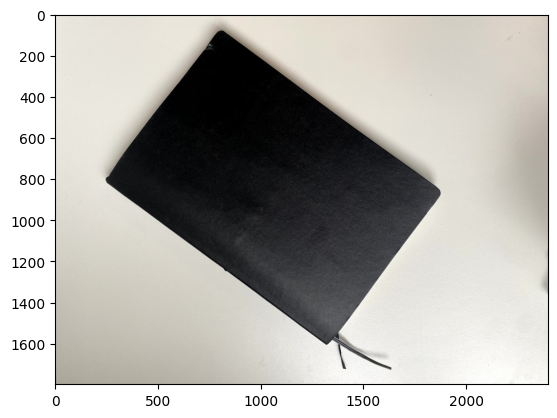

In [4]:
# load image as PyTorch tensor
img = load_img_as_tensor('/content/for_segmentation/notebook.jpg')
# get image dimensions
img_height, img_width, n_channels = img.shape
plt.imshow(img)

In [8]:
# convert pixels to data points and run K-means
X = img.view([-1, n_channels])
k = 2
means, labels = kmeans(X, k=k)

Distortion metric J=0.175004
Distortion metric J=0.073145
Distortion metric J=0.012508
Distortion metric J=0.011211


<ipython-input-11-48bf393ca429>:63: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_palette = torch.tensor(plt.cm.get_cmap('rainbow', K)(range(K))[:, :3] * 255, dtype=torch.uint8)


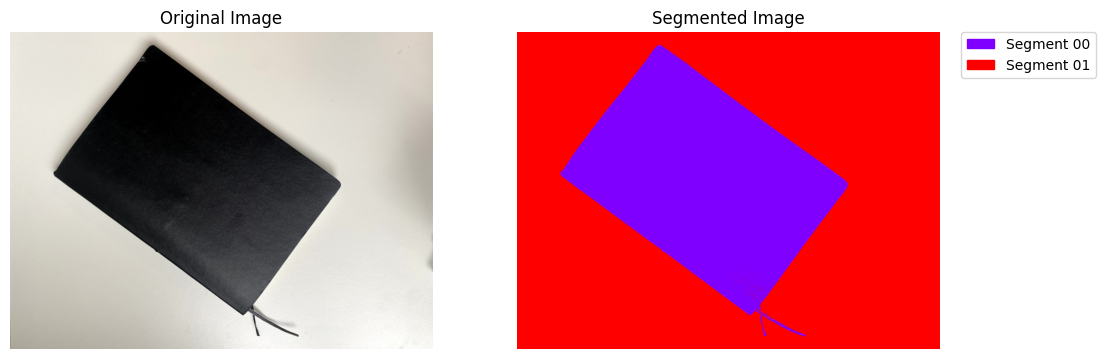

In [12]:
# plot the segmented image along with the input
labels_colors, color_palette = labels_to_colors(labels, k)
image_segments = labels_colors.view([img_height, img_width, 3])
show_image_with_segments(img, image_segments, k, color_palette, 'segmented_image.png')